In [113]:
import os
import re
import time

from glob import glob
from PIL import Image
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import torch
import torch.nn as nn
from torch import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD, RMSprop
from torch.autograd import Variable

from torchvision import transforms
from torchvision import models

import segmentation_models_pytorch as smp

from sklearn.model_selection import train_test_split, StratifiedKFold
from skimage import metrics

In [114]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset (Lung Segmentation)

You can download the dataset from here: https://www.kaggle.com/datasets/nikhilpandey360/chest-xray-masks-and-labels

In [115]:
data_dir = 'drive/MyDrive'

In [116]:
lung_image_paths = glob(os.path.join(data_dir, 'CXR_png', '*.png'))
mask_image_paths = glob(os.path.join(data_dir, 'masks', '*.png'))

In [117]:
len(lung_image_paths), len(mask_image_paths)

(800, 704)

In [118]:
def to_df(image_paths: list[str], mask_paths: list[str]) -> pd.DataFrame:
    df = pd.DataFrame({'image_path': image_paths})
    mask_set = set(mask_paths)
    df['mask_path'] = df['image_path'].apply(
        lambda img_path: img_path.replace('CXR_png', 'masks').replace('.png', '_mask.png')
                         if img_path.replace('CXR_png', 'masks').replace('.png', '_mask.png') in mask_set
                         else None
    )
    df = df.dropna()
    return df

In [119]:
df = to_df(lung_image_paths, mask_image_paths)

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 566 entries, 0 to 661
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  566 non-null    object
 1   mask_path   566 non-null    object
dtypes: object(2)
memory usage: 13.3+ KB


In [121]:
df.head()

,image_path,mask_path
0,drive/MyDrive/CXR_png/CHNCXR_0001_0.png,drive/MyDrive/masks/CHNCXR_0001_0_mask.png
1,drive/MyDrive/CXR_png/CHNCXR_0002_0.png,drive/MyDrive/masks/CHNCXR_0002_0_mask.png
2,drive/MyDrive/CXR_png/CHNCXR_0003_0.png,drive/MyDrive/masks/CHNCXR_0003_0_mask.png
3,drive/MyDrive/CXR_png/CHNCXR_0004_0.png,drive/MyDrive/masks/CHNCXR_0004_0_mask.png
4,drive/MyDrive/CXR_png/CHNCXR_0005_0.png,drive/MyDrive/masks/CHNCXR_0005_0_mask.png


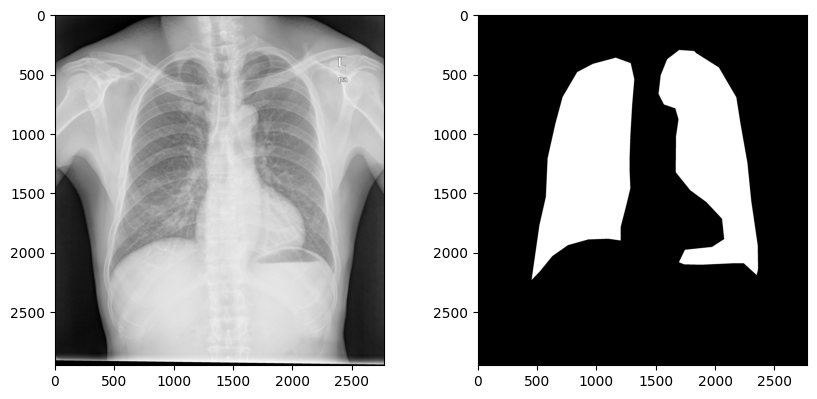

In [122]:
xray_num = 5
img_path = df["image_path"][xray_num]
mask_path = df["mask_path"][xray_num]

img = Image.open(img_path)
mask = Image.open(mask_path)

fig = plt.figure(figsize = (10,10))

ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img, cmap = "gray")
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(mask, cmap = "gray")
plt.show()

## Preprocessing

In [123]:
def prepare_train_test(df: pd.DataFrame, resize_shape: tuple, color_mode: str = "rgb"):
    img_array, mask_array = [], []

    for image_path in tqdm(df.image_path):
        resized_image = cv2.resize(cv2.imread(image_path), resize_shape) / 255.0 # normalize

        if color_mode == "gray":
            img_array.append(resized_image[:,:,0])
        elif color_mode == "rgb":
            img_array.append(resized_image[:,:,:])

    for mask_path in tqdm(df.mask_path):
        resized_mask = cv2.resize(cv2.imread(mask_path), resize_shape) / 255.0  # normalize
        mask_array.append(resized_mask[:,:,0])

    return np.array(img_array), np.array(mask_array)

In [124]:
img_array, mask_array = prepare_train_test(df = df, resize_shape = (224,224), color_mode = "gray")

100%|██████████| 566/566 [00:31<00:00, 18.08it/s]


In [125]:
img_array.shape, mask_array.shape

((566, 224, 224), (566, 224, 224))

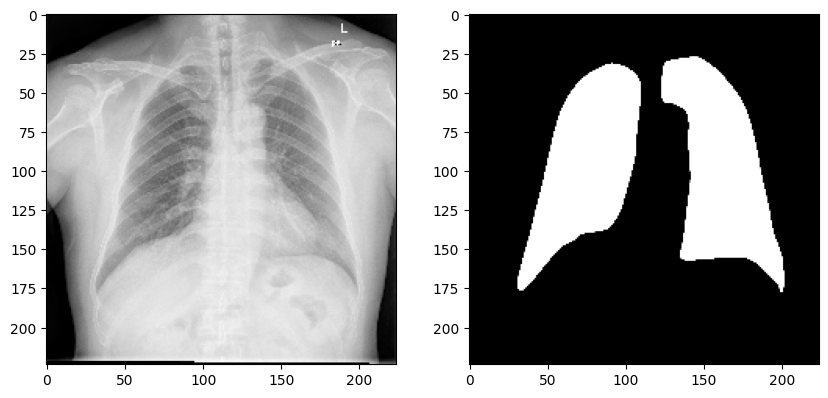

In [126]:
fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img_array[0], cmap = "gray")
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(mask_array[0], cmap = "gray")
plt.show()

## Split Data into train and test

In [127]:
split_ratio = round(len(img_array)*0.8)

In [128]:
X_train, X_test = img_array[:split_ratio], img_array[split_ratio:]
y_train, y_test = mask_array[:split_ratio], mask_array[split_ratio:]

In [129]:
len(X_train) + len(X_test)

566

## Pytorch Dataset / DataLoader

In [130]:
class MyDataset(Dataset):
    def __init__(self, data, targets, transform):
        self.data = data
        self.targets = targets
        self.transforms = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        if self.transforms:
            x = self.transforms(x)
            y = self.transforms(y)
        return x, y

    def __len__(self):
        return len(self.data)

In [131]:
dataset = MyDataset(X_train, y_train, transforms.ToTensor())
train_loader = DataLoader(dataset, batch_size=4)

testset = MyDataset(X_test, y_test, transforms.ToTensor())
val_loader = DataLoader(testset, batch_size=4)

In [132]:
import tqdm
for img,target in tqdm.tqdm(train_loader):
    z = 1

100%|██████████| 114/114 [00:00<00:00, 786.21it/s]


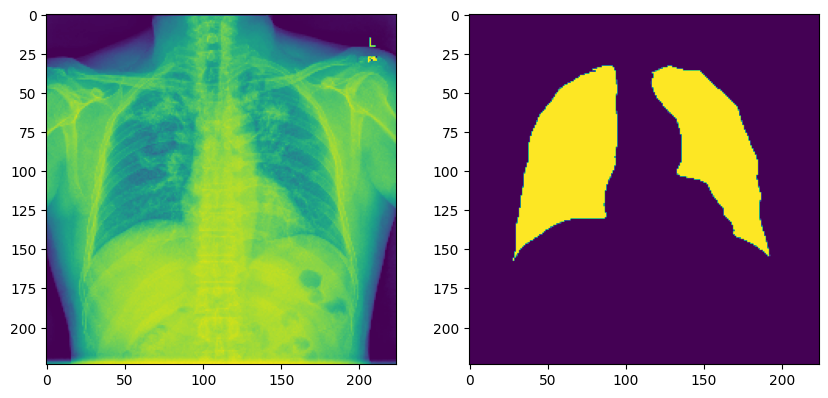

In [133]:
fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img[0][0])
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(target[0][0])
plt.show()

## Model U-NET

In [134]:
cuda = torch.cuda.is_available()

In [135]:
model = smp.Unet(
    encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    #encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

if cuda:
    model = model.cuda()

In [136]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

### Dice Loss

In [137]:
def dice_score(pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)
    intersection = (pred * target).sum()
    union = torch.sum(pred*pred) + torch.sum(target*target)

    return (2. * intersection + 1e-6) / (union + 1e-6)

In [138]:
def dice_loss(pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    dice = dice_score(pred, target)
    return 1 - dice

## Train the Model

In [139]:
criterion = dice_loss
optimizer = SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4)

In [140]:
losses = []
vlosses = []

In [141]:
iter_num = 0
n_epoch = 40
start_time = time.time()

for epoch_num in range(n_epoch):
    loss_ = []
    vloss_ = []
    for i_batch, sampled_batch in enumerate(train_loader):
        image_batch, label_batch = sampled_batch
        image_batch = image_batch.float()
        if cuda:
            image_batch, label_batch = image_batch.cuda(), label_batch.cuda()
        outputs = model(image_batch)
        outputs = torch.squeeze(outputs, 1)
        loss = criterion(outputs, label_batch.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    losses.append(np.mean(loss_,axis = 0))
    print('train epoch ',epoch_num)
    print('-------- train dice total', np.mean(loss_,axis = 0))
    with torch.no_grad():
        for i_batch, sampled_batch1 in enumerate(val_loader):
            image_batch1, label_batch1 = sampled_batch1
            image_batch1 = image_batch1.float()
            if cuda:
                image_batch1, label_batch1 = image_batch1.cuda(), label_batch1.cuda()
            outputs1 = model(image_batch1)
            outputs1 = torch.squeeze(outputs1, 1)
            vloss = criterion(outputs1, label_batch1.float())
            vloss_.append(vloss.item())
        vlosses.append(np.mean(vloss_,axis = 0))
        print('-------- test loss ', np.mean(vloss_,axis = 0))
end_time = time.time()

train epoch  0
-------- train dice total 0.1596751636580417
-------- test loss  0.042621996896020295
train epoch  1
-------- train dice total 0.051584504675446896
-------- test loss  0.03662876014051766
train epoch  2
-------- train dice total 0.04835708360922964
-------- test loss  0.03456805081203066
train epoch  3
-------- train dice total 0.0390124451695827
-------- test loss  0.03226500544054755
train epoch  4
-------- train dice total 0.031846540538888225
-------- test loss  0.03300373102056569
train epoch  5
-------- train dice total 0.028577870967095357
-------- test loss  0.04263647876936814
train epoch  6
-------- train dice total 0.02682581387068096
-------- test loss  0.04102149708517667
train epoch  7
-------- train dice total 0.024408508288232905
-------- test loss  0.035788431249815844
train epoch  8
-------- train dice total 0.022876179009153133
-------- test loss  0.036787610629509235
train epoch  9
-------- train dice total 0.022348132049828245
-------- test loss  0.0

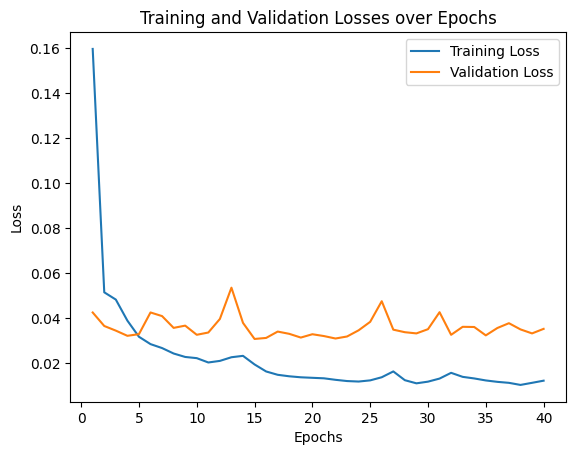

In [142]:
# Create a range of epochs for x-axis
epochs = range(1, len(losses) + 1)

# Plot training and validation losses on the same graph
plt.plot(epochs, losses, label='Training Loss')
plt.plot(epochs, vlosses, label='Validation Loss')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses over Epochs')

# Add legend
plt.legend()

# Show the plot
plt.show()

## Evaluate

In [143]:
model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [144]:
d = []

In [145]:
def one_mask(img):
    model.eval()
    transform = transforms.ToTensor()
    inputs = transform(img).unsqueeze(0)
    inputs = inputs.float()
    with torch.no_grad():
        if cuda:
            inputs = inputs.cuda()
        outputs = model(inputs)
    try:
        mask_pred = (outputs.cpu().numpy())
    except:
        mask_pred = np.zeros([512,512])
    return img, mask_pred

In [146]:
img, mask = one_mask(X_test[0])

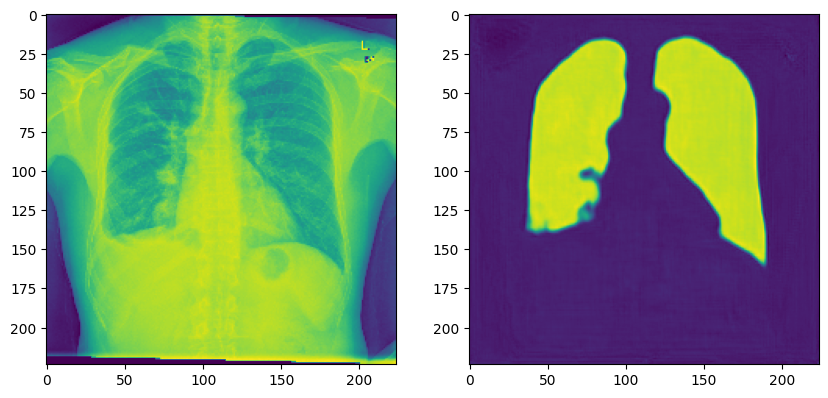

In [147]:
fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(mask[0][0])
plt.show()

In [148]:
model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [149]:
import numpy as np

def calculate_dice_coefficient(mask_true, mask_pred):
    intersect = np.sum(mask_pred*mask_true)
    return 2. * intersect.sum() / (mask_true.sum() + mask_pred.sum())

def precision_score(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    precision = np.mean(intersect/np.sum(pred_mask))
    return round(precision, 3)

def recall_score(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    recall = np.mean(intersect/np.sum(groundtruth_mask))
    return round(recall, 3)

def calculate_iou(mask_true, mask_pred):
    intersect = np.sum(mask_pred*mask_true)
    union = np.sum(mask_pred) + np.sum(mask_true) - intersect
    return np.mean(intersect/union)

def hausdorff_distance(mask1, mask2):
    return metrics.hausdorff_distance(mask1, mask2)

In [152]:
dice = []
hd = []
prec = []
rec = []
iou = []
for ind,img in enumerate(X_test):
    _,mask_pred = one_mask(img)
    mask_true = y_test[ind]
    dice.append(calculate_dice_coefficient(mask_true, mask_pred))
    hd.append(hausdorff_distance(mask_true, mask_pred[0][0]))
    prec.append(precision_score(mask_true, mask_pred))
    rec.append(recall_score(mask_true, mask_pred))
    iou.append(calculate_iou(mask_true, mask_pred))

In [153]:
print(np.mean(hd))
print(np.mean(dice))
print(np.mean(iou))
print(np.mean(prec))
print(np.mean(rec))

79.96402186460412
0.9450851604294292
0.896549709577936
0.9471769911504424
0.944
